In [1]:
import torch
# GPUが使用可能か判断
if torch.cuda.is_available():
    print('gpu is available')
else:
    raise Exception('gpu is NOT available')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

gpu is available


device(type='cuda')

In [2]:
# !pip install transformers[torch] datasets
# !pip install fugashi
# !pip install ipadic
# !pip install sentencepiece

In [3]:
# !pip install git+https://github.com/huggingface/accelerate
# !pip install --upgrade transformers

In [4]:
# !pip install optuna

In [2]:
from datasets import load_dataset, DatasetDict
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
from transformers import Trainer
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import pandas as pd
import torch
import random

In [3]:
from transformers.trainer_utils import set_seed

# 乱数シードを42に固定
set_seed(42)

In [4]:
from pprint import pprint
from datasets import load_dataset

# Hugging Face Hub上のllm-book/wrime-sentimentのリポジトリから
# データを読み込む
train_dataset = load_dataset("llm-book/wrime-sentiment", split="train", remove_neutral=False)
valid_dataset = load_dataset("llm-book/wrime-sentiment", split="validation", remove_neutral=False)
# pprintで見やすく表示する
pprint(train_dataset)
pprint(valid_dataset)

Dataset({
    features: ['sentence', 'label', 'user_id', 'datetime'],
    num_rows: 30000
})
Dataset({
    features: ['sentence', 'label', 'user_id', 'datetime'],
    num_rows: 2500
})


In [ ]:
# # 実験のためデータセットを縮小したい場合はコチラを有効化
# train_dataset = train_dataset.select(
#     random.sample(range(train_dataset.num_rows), k=500))
# valid_dataset = valid_dataset.select(
#     random.sample(range(valid_dataset.num_rows), k=500))
# pprint(train_dataset)
# pprint(valid_dataset)

In [5]:
# トークナイザのロード
model_name = "cl-tohoku/bert-base-japanese-whole-word-masking"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [6]:
# トークナイズ処理
def preprocess_text(batch):
    encoded_batch = tokenizer(batch['sentence'], max_length=512)
    encoded_batch['labels'] = batch['label']
    return encoded_batch

In [7]:
encoded_train_dataset = train_dataset.map(
    preprocess_text,
    remove_columns=train_dataset.column_names,
)
encoded_valid_dataset = valid_dataset.map(
    preprocess_text,
    remove_columns=valid_dataset.column_names,
)

In [8]:
# ミニバッチ構築
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [9]:
# モデルの準備
from transformers import AutoModelForSequenceClassification

class_label = train_dataset.features["label"]
label2id = {label: id for id, label in enumerate(class_label.names)}
id2label = {id: label for id, label in enumerate(class_label.names)}
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=class_label.num_classes,
    label2id=label2id,  # ラベル名からIDへの対応を指定
    id2label=id2label,  # IDからラベル名への対応を指定
)
print(type(model).__name__)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification


In [18]:
# 訓練用の設定
from transformers import TrainingArguments

# ベストパラメータ
best_batch = 16
best_lr = 1.0993302782107434e-05
best_lr_type = 'linear'
best_weight_decay = 2.8830588304824114e-05
# 保存ディレクトリ
save_dir = 'bert-base-japanese-v3-wrime-sentiment'

training_args = TrainingArguments(
    output_dir=save_dir,  # 結果の保存フォルダ
    optim='adafactor',  # オプティマイザの種類
    per_device_train_batch_size=best_batch,  # 訓練時のバッチサイズ
    per_device_eval_batch_size=best_batch,  # 評価時のバッチサイズ
    learning_rate=best_lr,  # 学習率
    lr_scheduler_type=best_lr_type,  # 学習率スケジューラの種類
    weight_decay=best_weight_decay,  # 正則化
    warmup_ratio=0.1,  # 学習率のウォームアップの長さを指定
    num_train_epochs=100,  # エポック数
    save_strategy="epoch",  # チェックポイントの保存タイミング
    logging_strategy="epoch",  # ロギングのタイミング
    evaluation_strategy="epoch",  # 検証セットによる評価のタイミング
    load_best_model_at_end=True,  # 訓練後に開発セットで最良のモデルをロード
    metric_for_best_model="accuracy",  # 最良のモデルを決定する評価指標
    fp16=True,  # 自動混合精度演算の有効化
)

In [11]:
# メトリクスの定義
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [12]:
# 訓練の実施
from transformers import Trainer
from transformers import EarlyStoppingCallback

trainer = Trainer(
    model=model,
    train_dataset=encoded_train_dataset,
    eval_dataset=encoded_valid_dataset,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.054600,0.878704,0.598400,0.571962
2,0.811200,0.726747,0.678000,0.674365
3,0.709500,0.689748,0.689600,0.687829
4,0.641100,0.669283,0.717200,0.715228
5,0.574600,0.665960,0.726400,0.726276
6,0.498000,0.693308,0.710800,0.713083
7,0.410700,0.743154,0.713200,0.715747
8,0.329900,0.830595,0.699600,0.699335


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.w

TrainOutput(global_step=15000, training_loss=0.6287019287109376, metrics={'train_runtime': 763.2036, 'train_samples_per_second': 3930.799, 'train_steps_per_second': 245.675, 'total_flos': 9113985676680192.0, 'train_loss': 0.6287019287109376, 'epoch': 8.0})

In [19]:
# モデルの保存
trainer.save_model(save_dir)
tokenizer.save_pretrained(save_dir)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


('bert-base-japanese-v3-wrime-sentiment/tokenizer_config.json',
 'bert-base-japanese-v3-wrime-sentiment/special_tokens_map.json',
 'bert-base-japanese-v3-wrime-sentiment/vocab.txt',
 'bert-base-japanese-v3-wrime-sentiment/added_tokens.json')

In [20]:
from sklearn.linear_model import LinearRegression

def linear_regression(history_df):
    y = history_df['eval_loss'].dropna().values
    x = np.arange(len(y)).reshape(-1, 1)
    linear = LinearRegression().fit(x, y)
    return linear

In [21]:
# 結果描画用関数
import matplotlib.pyplot as plt

def show_graph(df, suptitle, regression, output='output.png'):
    suptitle_size = 23
    graph_title_size = 20
    legend_size = 18
    ticks_size = 13
    # 学習曲線
    fig = plt.figure(figsize=(20, 5))
    # plt.suptitle(','.join([f'{e}: {parameters[e]}' for e in parameters.keys()]), fontsize=suptitle_size)
    plt.suptitle(suptitle, fontsize=suptitle_size)
    # Train Loss
    plt.subplot(131)
    plt.title('Train Loss', fontsize=graph_title_size)
    plt.plot(df['loss'].dropna(), label='train')
    plt.legend(fontsize=legend_size)
    plt.yticks(fontsize=ticks_size)
    # Validation Loss
    plt.subplot(132)
    reg_str = f'$y={round(regression.coef_[0],5)}*x+{round(regression.intercept_,3)}$'
    plt.title(f'Val Loss', fontsize=graph_title_size)
    y = df['eval_loss'].dropna().values
    x = np.arange(len(y)).reshape(-1, 1)
    pred = regression.coef_ * x.ravel() + regression.intercept_  # 線形回帰直線
    plt.plot(y, color='tab:orange', label='val')
    plt.plot(pred, color='green', label='pred')
    plt.legend(fontsize=legend_size)
    plt.xlabel(reg_str, fontsize=ticks_size)
    plt.yticks(fontsize=ticks_size)
    # Accuracy/F1
    plt.subplot(133)
    plt.title('eval Accuracy/F1', fontsize=graph_title_size)
    plt.plot(df['eval_accuracy'].dropna(), label='accuracy')
    plt.plot(df['eval_f1'].dropna(), label='F1')
    plt.legend(fontsize=legend_size)
    plt.yticks(fontsize=ticks_size)
    plt.tight_layout()
    # plt.show()
    plt.savefig(output)




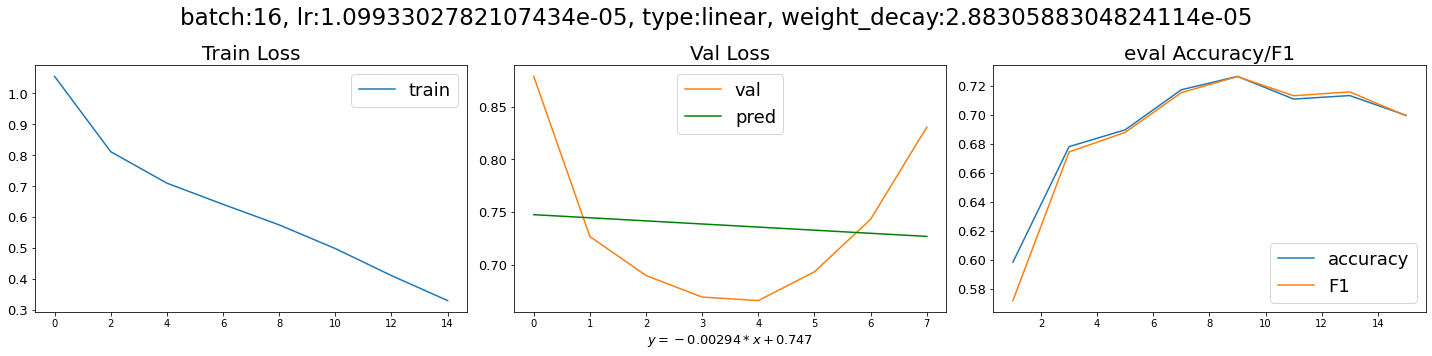

In [22]:
history_df = pd.DataFrame(trainer.state.log_history)
# 結果を表示
suptitle = f'batch:{best_batch}, lr:{best_lr}, type:{best_lr_type}, weight_decay:{best_weight_decay}'
reg = linear_regression(history_df)
show_graph(history_df, suptitle, reg, f'{save_dir}/output.png')